# Setting up and importing libs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install shap

In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 17.1 MB/s eta 0:00:00


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [5]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 5000)
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as stats
import shap

import optuna
from optuna.samplers import TPESampler

In [6]:
np.random.seed(42)

In [7]:
test_data = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Classification/Binary Classification with a Bank Dataset/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Classification/Binary Classification with a Bank Dataset/train.csv')
original_data = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Classification/Binary Classification with a Bank Dataset/bank-full.csv', sep=';')

In [8]:
train_data

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [9]:
original_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [10]:
original_data['y'] = original_data['y'].replace({'yes': 1, 'no': 0})

#Preprocess data

##Concatenating original data

In [11]:
train_data = pd.concat([train_data.drop(['id'], axis=1), original_data],ignore_index=True)
train_data
# train_data =train_data.drop(['id'], axis=1)
# train_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
795207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
795208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
795209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


##Handle Missing Data

In [12]:
train_data['contact'].unique()

array(['cellular', 'unknown', 'telephone'], dtype=object)

In [13]:
train_data.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [14]:
# train_data.dropna(inplace =True)
# train_data

##Duplicate

In [15]:
train_data.duplicated().sum()

np.int64(0)

In [16]:
train_data.drop_duplicates(inplace = True)
train_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
795207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
795208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
795209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795211 entries, 0 to 795210
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        795211 non-null  int64 
 1   job        795211 non-null  object
 2   marital    795211 non-null  object
 3   education  795211 non-null  object
 4   default    795211 non-null  object
 5   balance    795211 non-null  int64 
 6   housing    795211 non-null  object
 7   loan       795211 non-null  object
 8   contact    795211 non-null  object
 9   day        795211 non-null  int64 
 10  month      795211 non-null  object
 11  duration   795211 non-null  int64 
 12  campaign   795211 non-null  int64 
 13  pdays      795211 non-null  int64 
 14  previous   795211 non-null  int64 
 15  poutcome   795211 non-null  object
 16  y          795211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.1+ MB


#EDA

##Distribution of Target

<Axes: xlabel='y', ylabel='count'>

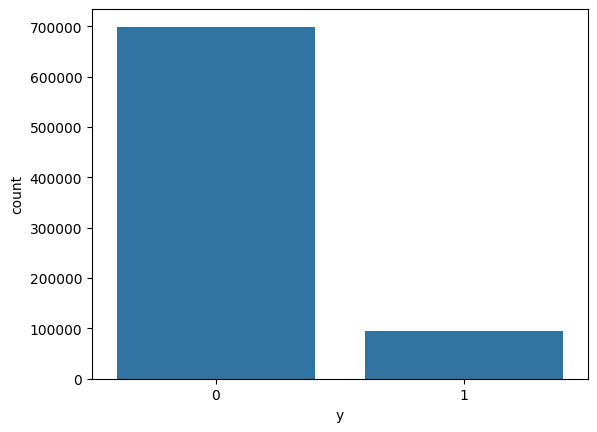

In [18]:
sns.countplot(data= train_data, x = 'y')

Huge Imbalance (stratification might be needed)

##Heatmap

In [19]:
Categorical_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
num_cols = train_data.columns
num_cols = num_cols.drop(Categorical_cols)
num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y'],
      dtype='object')

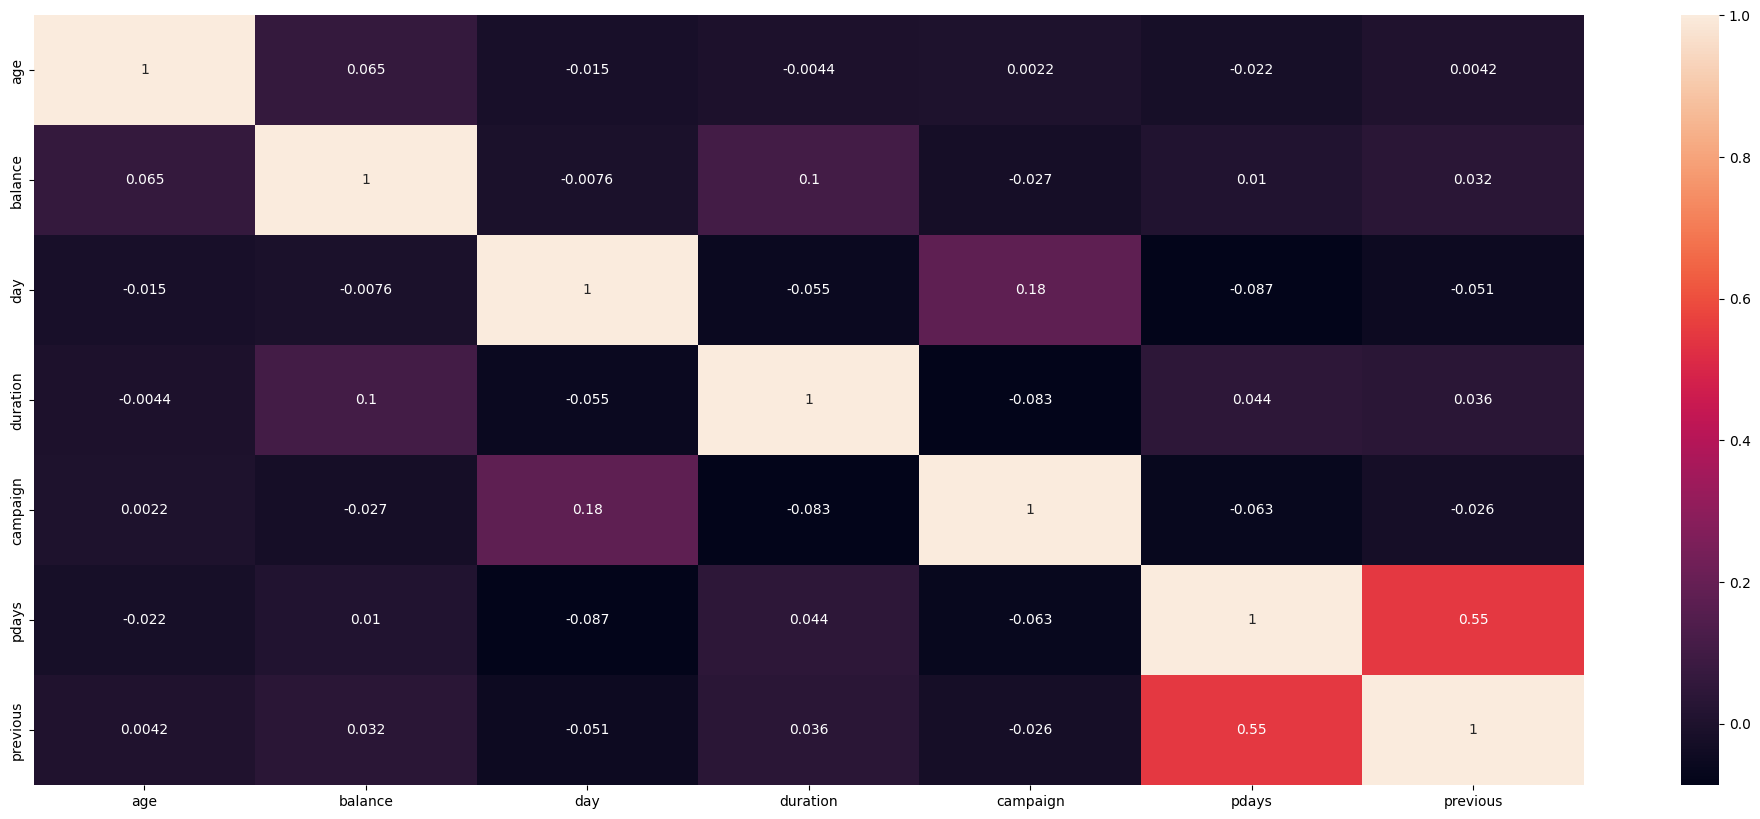

In [20]:
plt.figure(figsize=(25,10))
sns.heatmap((train_data[num_cols].drop(columns='y')).corr(),annot=True)
plt.show()

##Mutual Info

In [21]:
from sklearn.feature_selection import mutual_info_classif

y_sampled = train_data.y
mutual_df = train_data[num_cols].drop(['y'], axis=1)

mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
duration,0.148780
balance,0.068309
pdays,0.029613
campaign,0.026107
age,0.018548
day,0.014419
previous,0.011933


##Distributions

###Numerical

Text(0.5, 0.98, 'Visualizing Continuous Columns')

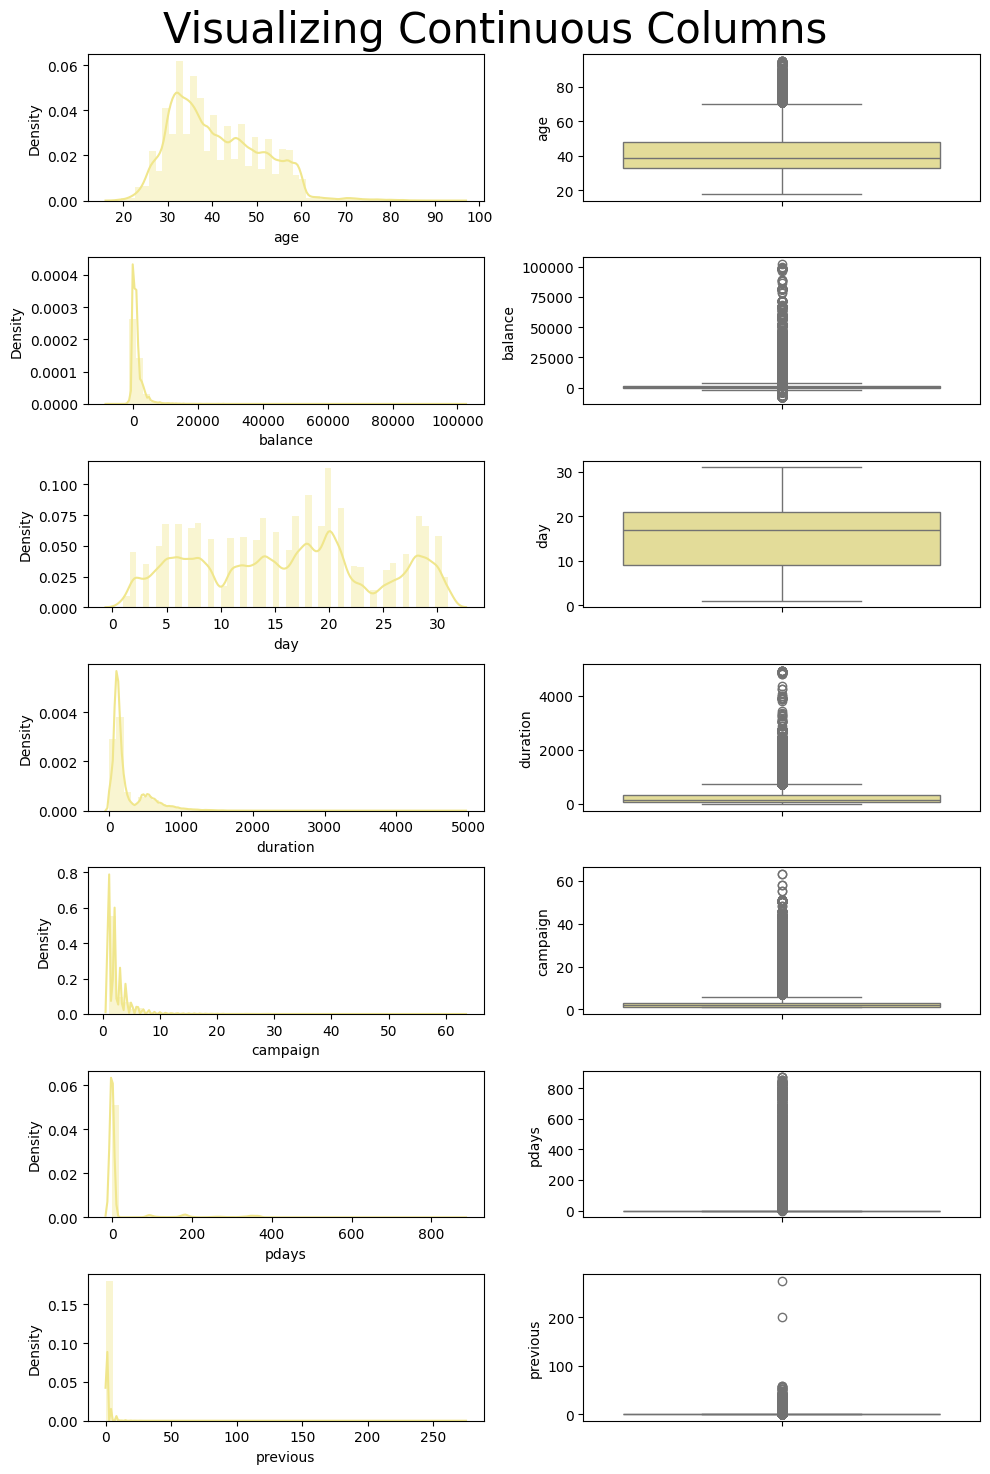

In [22]:
fig, ax = plt.subplots(7,2,figsize=(10,15))
for index,i in enumerate(num_cols.drop("y")):
    sns.distplot(train_data[i],ax=ax[index,0], color = 'khaki')
    sns.boxplot(train_data[i],ax=ax[index,1], color = 'khaki')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing Continuous Columns",fontsize=30)

###Categorical

Text(0.5, 0.98, 'Visualizing Categorical Columns')

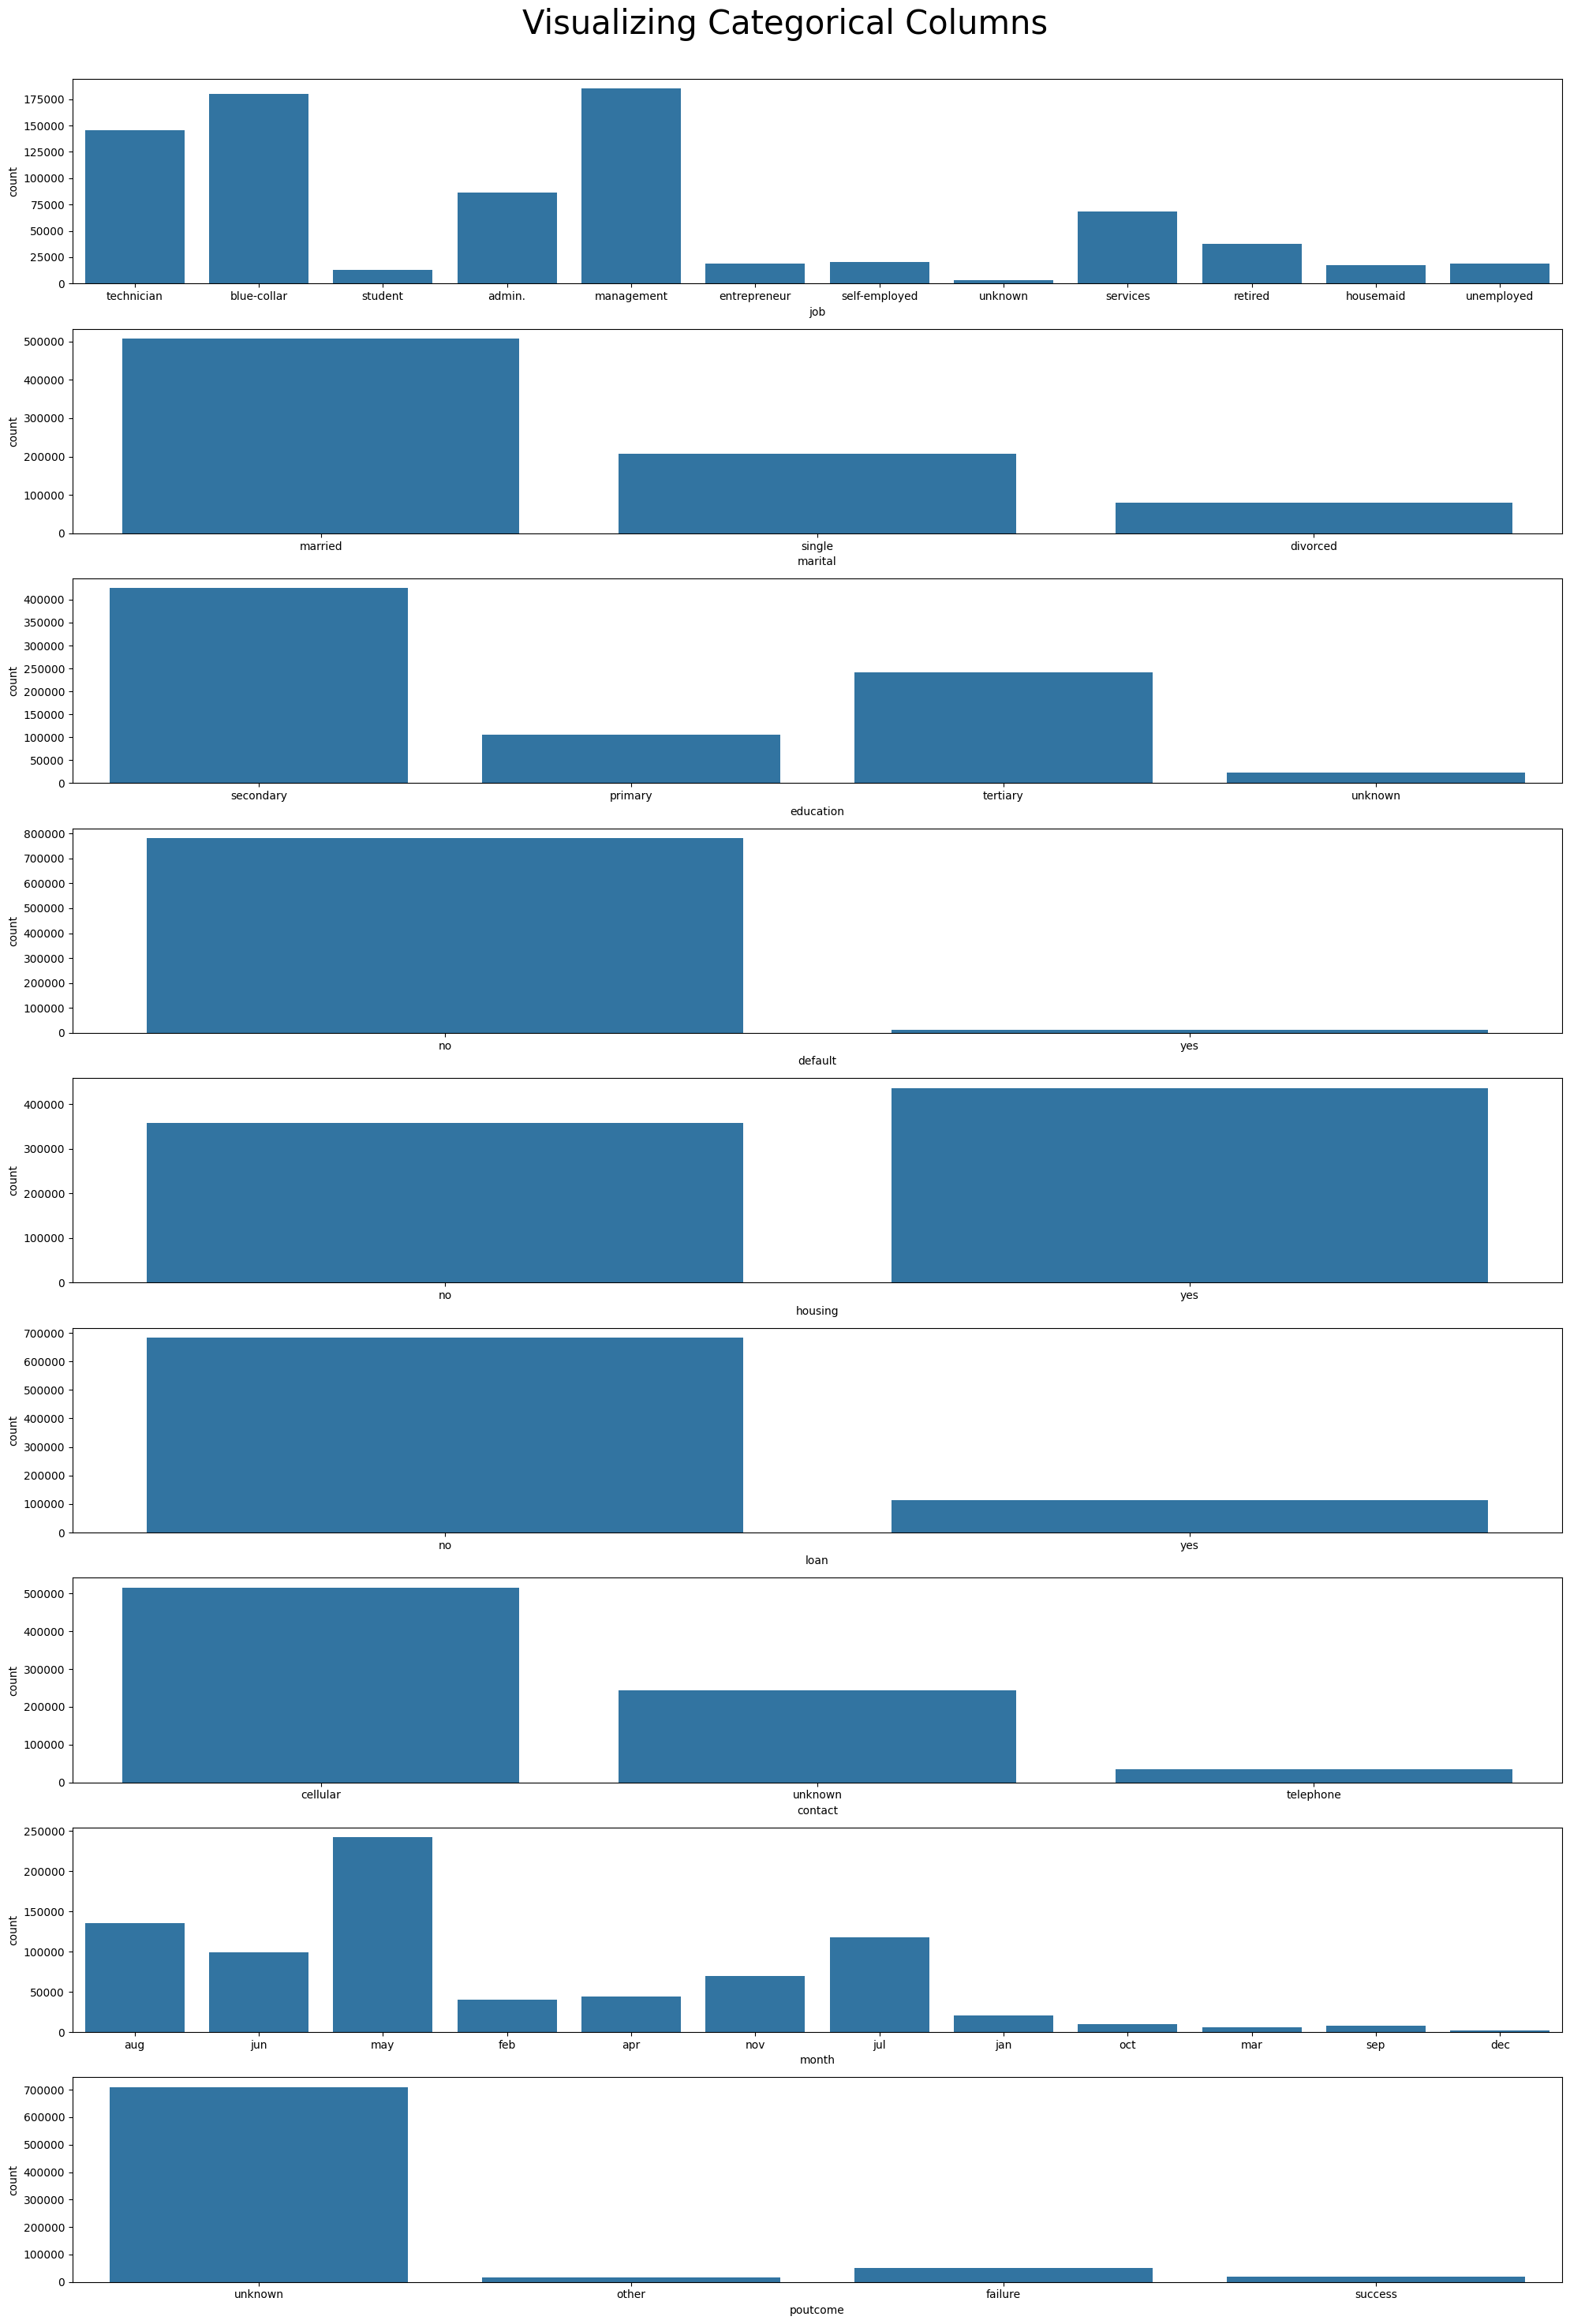

In [23]:
fig, ax = plt.subplots(9,1,figsize=(20,30))
for index,i in enumerate(Categorical_cols):
  sns.countplot(data= train_data, ax=ax[index], x = i)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing Categorical Columns",fontsize=30)


##Feature Engineering

In [24]:
from sklearn.preprocessing import LabelEncoder

# Make a copy so we don't overwrite original
df = train_data.copy()


# Log transform balance (reduce skew)
df['balance_clipped'] = df['balance'].clip(lower=0)
df['balance_log'] = np.round(np.log1p(df['balance_clipped']), 6).astype(np.float32)
df.drop(columns=['balance_clipped'], inplace=True)

df['log_duration'] = np.log1p(df['duration'])


# Encoding

binary_map = {'yes': 1, 'no': 0}
df['default'] = df['default'].map(binary_map)
df['housing'] = df['housing'].map(binary_map)
df['loan'] = df['loan'].map(binary_map)

# df['y'] = df['y'].astype(int)  # 0 or 1

multi_cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)


df


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,7,0,0,25,117,3,-1,0,0,2.079442,4.770685,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38,0,514,0,0,18,185,1,-1,0,0,6.244167,5.225747,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,36,0,602,1,0,14,111,2,-1,0,0,6.401917,4.718499,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,27,0,34,1,0,28,10,2,-1,0,0,3.555348,2.397895,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,26,0,889,1,0,3,902,1,-1,0,1,6.791221,6.805723,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,0,825,0,0,17,977,3,-1,0,1,6.716595,6.885510,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795207,71,0,1729,0,0,17,456,2,-1,0,1,7.455877,6.124683,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795208,72,0,5715,0,0,17,1127,5,184,3,1,8.651025,7.028201,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
795209,57,0,668,0,0,17,508,4,-1,0,0,6.505784,6.232448,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [25]:
train_data = df.copy()

train_data = train_data.drop(columns=['balance', 'duration'], errors='ignore')
train_data

,age,default,housing,loan,day,campaign,pdays,previous,y,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,0,0,25,3,-1,0,0,2.079442,4.770685,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38,0,0,0,18,1,-1,0,0,6.244167,5.225747,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,36,0,1,0,14,2,-1,0,0,6.401917,4.718499,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,27,0,1,0,28,2,-1,0,0,3.555348,2.397895,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,26,0,1,0,3,1,-1,0,1,6.791221,6.805723,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,0,0,0,17,3,-1,0,1,6.716595,6.885510,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795207,71,0,0,0,17,2,-1,0,1,7.455877,6.124683,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795208,72,0,0,0,17,5,184,3,1,8.651025,7.028201,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
795209,57,0,0,0,17,4,-1,0,0,6.505784,6.232448,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [26]:
from sklearn.preprocessing import LabelEncoder

df = test_data.copy()



# Log transform balance (reduce skew)
df['balance_clipped'] = df['balance'].clip(lower=0)
df['balance_log'] = np.round(np.log1p(df['balance_clipped']), 6).astype(np.float32)
df.drop(columns=['balance_clipped'], inplace=True)

df['log_duration'] = np.log1p(df['duration'])


# Encoding

binary_map = {'yes': 1, 'no': 0}
df['default'] = df['default'].map(binary_map)
df['housing'] = df['housing'].map(binary_map)
df['loan'] = df['loan'].map(binary_map)

# df['y'] = df['y'].astype(int)  # 0 or 1

multi_cat_cols = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)


df


,id,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,750000,32,0,1397,1,0,21,224,1,-1,0,7.242798,5.416100,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,750001,44,0,23,1,0,3,586,2,-1,0,3.178054,6.375025,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,750002,36,0,46,1,1,13,111,2,-1,0,3.850148,4.718499,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,750003,58,0,-1380,1,1,29,125,1,-1,0,0.000000,4.836282,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,750004,28,0,1950,1,0,22,181,1,-1,0,7.576097,5.204007,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,0,0,1,0,18,65,2,-1,0,0.000000,4.189655,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
249996,999996,40,0,522,1,0,19,531,1,189,1,6.259581,6.276643,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
249997,999997,63,0,33,0,0,3,178,1,92,8,3.526361,5.187386,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
249998,999998,50,0,2629,1,0,30,163,2,-1,0,7.874739,5.099866,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True


In [27]:
test_data = df.copy()

test_data = test_data.drop(columns=['balance', 'duration'], errors='ignore')
test_data

,id,age,default,housing,loan,day,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,750000,32,0,1,0,21,1,-1,0,7.242798,5.416100,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,750001,44,0,1,0,3,2,-1,0,3.178054,6.375025,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,750002,36,0,1,1,13,2,-1,0,3.850148,4.718499,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,750003,58,0,1,1,29,1,-1,0,0.000000,4.836282,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,750004,28,0,1,0,22,1,-1,0,7.576097,5.204007,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,0,1,0,18,2,-1,0,0.000000,4.189655,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
249996,999996,40,0,1,0,19,1,189,1,6.259581,6.276643,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
249997,999997,63,0,0,0,3,1,92,8,3.526361,5.187386,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
249998,999998,50,0,1,0,30,2,-1,0,7.874739,5.099866,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True


##Label Encoding/ One hot enccoding

In [28]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# for i in Categorical_cols:
#   train_data[i] = label_encoder.fit_transform(train_data[i])
#   test_data[i] = label_encoder.fit_transform(test_data[i])
# train_data[Categorical_cols]

In [29]:
# import pandas as pd

# # Assuming 'Categorical_cols' is a list of categorical column names in your dataset
# # For One-Hot Encoding, we'll use pd.get_dummies

# # Apply One-Hot Encoding to both train_data and test_data
# train_data = pd.get_dummies(train_data, columns=Categorical_cols, drop_first=False)
# test_data = pd.get_dummies(test_data, columns=Categorical_cols, drop_first=False)

# # Check the resulting one-hot encoded columns
# train_data

In [30]:
train_data

,age,default,housing,loan,day,campaign,pdays,previous,y,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,0,0,25,3,-1,0,0,2.079442,4.770685,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38,0,0,0,18,1,-1,0,0,6.244167,5.225747,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,36,0,1,0,14,2,-1,0,0,6.401917,4.718499,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,27,0,1,0,28,2,-1,0,0,3.555348,2.397895,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,26,0,1,0,3,1,-1,0,1,6.791221,6.805723,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,0,0,0,17,3,-1,0,1,6.716595,6.885510,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795207,71,0,0,0,17,2,-1,0,1,7.455877,6.124683,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795208,72,0,0,0,17,5,184,3,1,8.651025,7.028201,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
795209,57,0,0,0,17,4,-1,0,0,6.505784,6.232448,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [31]:
test_data

,id,age,default,housing,loan,day,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,750000,32,0,1,0,21,1,-1,0,7.242798,5.416100,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,750001,44,0,1,0,3,2,-1,0,3.178054,6.375025,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,750002,36,0,1,1,13,2,-1,0,3.850148,4.718499,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,750003,58,0,1,1,29,1,-1,0,0.000000,4.836282,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,750004,28,0,1,0,22,1,-1,0,7.576097,5.204007,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,0,1,0,18,2,-1,0,0.000000,4.189655,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
249996,999996,40,0,1,0,19,1,189,1,6.259581,6.276643,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
249997,999997,63,0,0,0,3,1,92,8,3.526361,5.187386,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
249998,999998,50,0,1,0,30,2,-1,0,7.874739,5.099866,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True


#Modeling

##Finding the baseline model

In [32]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

rfc = RandomForestClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
lsvc = LinearSVC()
knn = KNeighborsClassifier()
gbc = GradientBoostingClassifier()
nb = GaussianNB()
base_xgb = XGBClassifier()
lgbm = LGBMClassifier()
cb = CatBoostClassifier()

In [33]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)


In [34]:
X = train_data.drop(columns='y')
X

,age,default,housing,loan,day,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,0,0,25,3,-1,0,2.079442,4.770685,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38,0,0,0,18,1,-1,0,6.244167,5.225747,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,36,0,1,0,14,2,-1,0,6.401917,4.718499,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,27,0,1,0,28,2,-1,0,3.555348,2.397895,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,26,0,1,0,3,1,-1,0,6.791221,6.805723,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,0,0,0,17,3,-1,0,6.716595,6.885510,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795207,71,0,0,0,17,2,-1,0,7.455877,6.124683,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795208,72,0,0,0,17,5,184,3,8.651025,7.028201,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
795209,57,0,0,0,17,4,-1,0,6.505784,6.232448,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [35]:
Y = train_data['y']
Y

,y
0,0
1,0
2,0
3,0
4,1
...,...
795206,1
795207,1
795208,1
795209,0


In [36]:
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score

def compute(model):
    lst_accu_stratified = []

    for train_index, test_index in cv.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train)
        y_pred_proba = model.predict_proba(X_test)
        auc_score = roc_auc_score(Y_test, y_pred_proba[:, 1])
        lst_accu_stratified.append(auc_score)

    max_val_score = max(lst_accu_stratified)
    min_val_score = min(lst_accu_stratified)
    mean_val_score = mean(lst_accu_stratified)
    std = stdev(lst_accu_stratified)

    hashmap[str(model)]=([mean_val_score, max_val_score, min_val_score, std])

## This is made so that it doesnt compute (takes way too long)

In [ ]:
model_names = [rfc,
    lr,
    # dtc,
    # knn,
    # gbc,
    # nb,
    base_xgb,
    lgbm,
    cb]

hashmap = {}
for i in model_names:
  compute(i)

In [ ]:
score = pd.DataFrame(hashmap)
score = score.transpose()
score.columns=['mean_val_score', 'max_val_score', 'min_val_score', 'std']
score = score.sort_values('mean_val_score',ascending=False)
score

##Feature importancce

In [ ]:
from matplotlib import pyplot

def checking_feature_imp(model, X, top_n=10):
    # Get feature importances and sort them
    importances = model.feature_importances_
    feature_names = X.columns

    # Get the top 'top_n' most important features (sorted in descending order)
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    # Print sorted feature importances (top_n)
    for i, v in enumerate(sorted_importances):
        print(f'{sorted_features[i]}: {v: 5f}')

    # Plot
    pyplot.barh(sorted_features, sorted_importances)
    pyplot.xlabel('Feature Importance')
    pyplot.title(f'Top {top_n} Feature Importances')
    pyplot.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=42)
def checking_shap_values(model):
  explainer = shap.Explainer(model, X_train)

  # Get SHAP values for the test set
  shap_values = explainer(X_test)

  # Plot summary plot
  shap.summary_plot(shap_values, X_test)

In [ ]:
well_performed_clf = [lgbm, base_xgb, cb]
for each_clf in well_performed_clf:
  print(each_clf)
  #checking_feature_imp(each_clf)
  checking_shap_values(each_clf)
  print()

#Tuning baseline model with Optuna

###LGBM

In [ ]:
from lightgbm import log_evaluation, early_stopping
def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 3,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
    }

    model = LGBMClassifier(**param)

    lst_accu_stratified = []

    for train_index, test_index in cv.split(X, Y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)],  callbacks=[early_stopping(stopping_rounds=50, verbose=False)])
        y_pred_proba = model.predict_proba(X_val)
        auc_score = roc_auc_score(Y_val, y_pred_proba[:, 1])
        lst_accu_stratified.append(auc_score)

    mean_val_score = mean(lst_accu_stratified)
    std_auc = stdev(lst_accu_stratified)

    trial.set_user_attr("std_auc", std_auc)
    trial.set_user_attr("all_auc_scores", lst_accu_stratified)
    # model.fit(X_train, Y_train)
    # y_pred = model.predict(X_test)
    # mean_val_score = accuracy_score(Y_test, y_pred)

    return mean_val_score

In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2025-08-17 22:47:56,357] A new study created in memory with name: no-name-ae336a5b-23f8-47a5-b102-fc061325a4a8
[I 2025-08-17 22:59:11,256] Trial 0 finished with value: 0.9625442639347089 and parameters: {'lambda_l1': 9.976822421671043, 'lambda_l2': 6.77647449475462, 'num_leaves': 44, 'feature_fraction': 0.47791505659066497, 'bagging_fraction': 0.5555057589890016, 'bagging_freq': 3, 'min_child_samples': 59, 'learning_rate': 0.021174645792980475, 'n_estimators': 390}. Best is trial 0 with value: 0.9625442639347089.
[I 2025-08-17 23:04:50,662] Trial 1 finished with value: 0.9571613760651638 and parameters: {'lambda_l1': 4.308981439867497, 'lambda_l2': 9.918753633358145, 'num_leaves': 120, 'feature_fraction': 0.6939912346287045, 'bagging_fraction': 0.8080185513831653, 'bagging_freq': 7, 'min_child_samples': 11, 'learning_rate': 0.003910593946214863, 'n_estimators': 156}. Best is trial 0 with value: 0.9625442639347089.
[I 2025-08-17 23:16:39,165] Trial 2 finished with value: 0.9656108169

KeyboardInterrupt: 

In [ ]:
# Sort all completed trials by objective value (mean AUC), descending
sorted_trials = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE],
    key=lambda t: t.value,
    reverse=True
)

# Print top 10 trials
for i, t in enumerate(sorted_trials[:10]):
    std_auc = t.user_attrs.get('std_auc', None)
    auc_scores = t.user_attrs.get('all_auc_scores', None)

    print(f"Trial {t.number}:")
    print(f"  Mean AUC: {t.value:.5f}")
    if std_auc is not None:
        print(f"  Std AUC: {std_auc:.5f}")
    if auc_scores is not None:
        print(f"  Fold AUCs: {auc_scores}")
    print()

In [38]:
# Best accuracy:  0.9674784566385135
best_params_lgbm = {'lambda_l1': 0.5715842498810308, 'lambda_l2': 1.7436305410688773, 'num_leaves': 253, 'feature_fraction': 0.4735610475772436, 'bagging_fraction': 0.9430383408794584, 'bagging_freq': 1, 'min_child_samples': 63, 'learning_rate': 0.07120867383622584, 'n_estimators': 346}
optimized_lgbm = LGBMClassifier(**best_params_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.7752743827110101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752743827110101
[LightGBM] [Warning] lambda_l2 is set=3.5512957384770685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5512957384770685
[LightGBM] [Warning] lambda_l1 is set=5.316935265388215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.316935265388215
[LightGBM] [Warning] bagging_fraction is set=0.9547952331300819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547952331300819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7752743827110101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752743827110101
[LightGBM] [Warning] lambda_l2 is set=3.5512957384770685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5512957384770685
[LightGBM] [Warning] lambda_l1 is set=

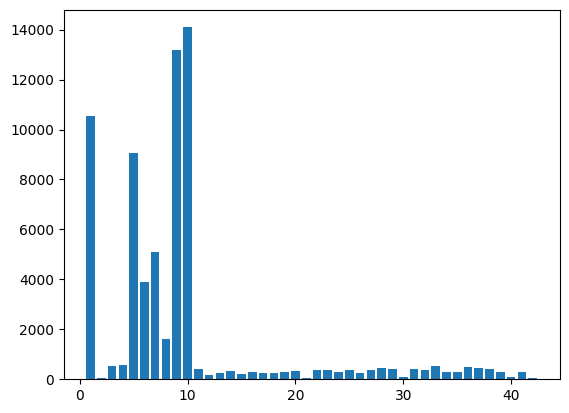

In [ ]:
optimized_lgbm.fit(X, Y)

# Call with booster fix
checking_feature_imp(optimized_lgbm)


###CatBoost

In [ ]:
def objective(trial):
    # Define the hyperparameter search space for CatBoost
    param = {
        'objective': 'Logloss',  # For binary classification
        'eval_metric': 'AUC',  # AUC is suitable for binary classification
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'verbose': 0  # Suppress output
    }

    model = CatBoostClassifier(**param)

    lst_accu_stratified = []

    for train_index, test_index in cv.split(X, Y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train, eval_set=(X_val, Y_val), early_stopping_rounds=50, verbose=False)
        y_pred_proba = model.predict_proba(X_val)
        auc_score = roc_auc_score(Y_val, y_pred_proba[:, 1])
        lst_accu_stratified.append(auc_score)

    mean_val_score = mean(lst_accu_stratified)
    std_auc = stdev(lst_accu_stratified)

    trial.set_user_attr("std_auc", std_auc)
    trial.set_user_attr("all_auc_scores", lst_accu_stratified)

    return mean_val_score

In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2025-08-14 19:08:01,638] A new study created in memory with name: no-name-da30eac8-6da0-4acc-bbd2-660e551dbd50
[I 2025-08-14 19:15:01,372] Trial 0 finished with value: 0.9633658537689915 and parameters: {'iterations': 384, 'depth': 10, 'learning_rate': 0.08001252425420578, 'random_strength': 7.997666052157022, 'bagging_temperature': 0.3286224219546813, 'l2_leaf_reg': 0.5457215177364405, 'border_count': 252, 'scale_pos_weight': 8.75144857527748}. Best is trial 0 with value: 0.9633658537689915.
[I 2025-08-14 19:19:11,406] Trial 1 finished with value: 0.9602880503042962 and parameters: {'iterations': 481, 'depth': 4, 'learning_rate': 0.08413811985733217, 'random_strength': 3.3781694307785997, 'bagging_temperature': 0.0974192363681875, 'l2_leaf_reg': 2.5829473137241363, 'border_count': 113, 'scale_pos_weight': 5.6285773808597925}. Best is trial 0 with value: 0.9633658537689915.
[I 2025-08-14 19:21:37,887] Trial 2 finished with value: 0.9386133161778009 and parameters: {'iterations': 299

In [ ]:
# Sort all completed trials by objective value (mean AUC), descending
sorted_trials = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE],
    key=lambda t: t.value,
    reverse=True
)

# Print top 10 trials
for i, t in enumerate(sorted_trials[:10]):
    std_auc = t.user_attrs.get('std_auc', None)
    auc_scores = t.user_attrs.get('all_auc_scores', None)

    print(f"Trial {t.number}:")
    print(f"  Mean AUC: {t.value:.5f}")
    if std_auc is not None:
        print(f"  Std AUC: {std_auc:.5f}")
    if auc_scores is not None:
        print(f"  Fold AUCs: {auc_scores}")
    print()

Trial 43:
  Mean AUC: 0.96452
  Std AUC: 0.00076
  Fold AUCs: [np.float64(0.9652076578102761), np.float64(0.9639057433493926), np.float64(0.9635073819520625), np.float64(0.9649817100668103), np.float64(0.9649817463748865)]

Trial 41:
  Mean AUC: 0.96447
  Std AUC: 0.00071
  Fold AUCs: [np.float64(0.9651496586206636), np.float64(0.9639078715167678), np.float64(0.9635180970555426), np.float64(0.9649177049431759), np.float64(0.9648339339437115)]

Trial 42:
  Mean AUC: 0.96440
  Std AUC: 0.00072
  Fold AUCs: [np.float64(0.9651568971840369), np.float64(0.9637898391183277), np.float64(0.963501209986775), np.float64(0.9647378939264167), np.float64(0.9648379426668962)]

Trial 48:
  Mean AUC: 0.96439
  Std AUC: 0.00066
  Fold AUCs: [np.float64(0.9649842788867485), np.float64(0.9638690284036302), np.float64(0.9634895251256581), np.float64(0.9647597458482622), np.float64(0.9648260982370732)]

Trial 44:
  Mean AUC: 0.96423
  Std AUC: 0.00071
  Fold AUCs: [np.float64(0.9649240092728665), np.float64

In [ ]:
#Best accuracy: 0.9645168479106856
best_param_cat ={'iterations': 495, 'depth': 10, 'learning_rate': 0.08897274440822697, 'random_strength': 6.964982554003085, 'bagging_temperature': 0.2741994856488808, 'l2_leaf_reg': 8.542809340803334, 'border_count': 253, 'scale_pos_weight': 1.908707113611698}
optimized_cat = CatBoostClassifier(**best_param_cat)

In [ ]:
  # Mean AUC: 0.96407
  # Std AUC: 0.00064
best_param_cat =  {'iterations': 499, 'depth': 10, 'learning_rate': 0.08592154000209568, 'random_strength': 4.594326184662999, 'bagging_temperature': 0.961874952342092, 'l2_leaf_reg': 2.8467533128677, 'border_count': 176, 'scale_pos_weight': 8.3544579796511}
optimized_cat = CatBoostClassifier(**best_param_cat)


0:	learn: 0.5945316	total: 837ms	remaining: 6m 18s
1:	learn: 0.5146364	total: 1.48s	remaining: 5m 32s
2:	learn: 0.4561751	total: 2.07s	remaining: 5m 10s
3:	learn: 0.4147106	total: 2.9s	remaining: 5m 26s
4:	learn: 0.3800002	total: 3.71s	remaining: 5m 32s
5:	learn: 0.3567694	total: 4.33s	remaining: 5m 22s
6:	learn: 0.3383416	total: 5.15s	remaining: 5m 27s
7:	learn: 0.3258013	total: 5.96s	remaining: 5m 31s
8:	learn: 0.3163847	total: 6.58s	remaining: 5m 24s
9:	learn: 0.3080882	total: 7.75s	remaining: 5m 43s
10:	learn: 0.3010826	total: 8.83s	remaining: 5m 54s
11:	learn: 0.2946225	total: 10.1s	remaining: 6m 12s
12:	learn: 0.2902261	total: 11.1s	remaining: 6m 15s
13:	learn: 0.2851450	total: 12s	remaining: 6m 15s
14:	learn: 0.2817005	total: 12.7s	remaining: 6m 10s
15:	learn: 0.2797142	total: 13.5s	remaining: 6m 8s
16:	learn: 0.2772956	total: 14.2s	remaining: 6m 3s
17:	learn: 0.2750808	total: 14.9s	remaining: 5m 59s
18:	learn: 0.2730534	total: 15.7s	remaining: 5m 57s
19:	learn: 0.2716540	total:

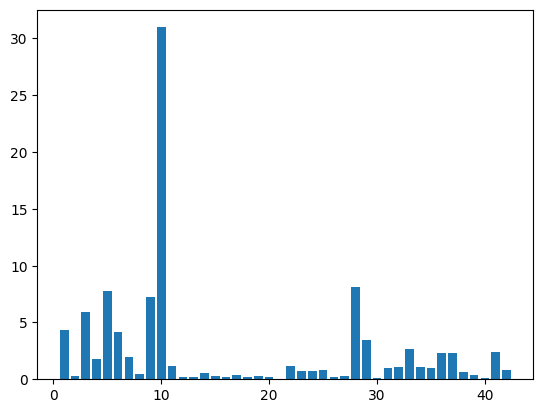

In [ ]:
#SHAP
optimized_cat.fit(X,Y)
checking_feature_imp(optimized_cat)

###XGB

In [ ]:
def objective(trial):
    param = {
        'objective': 'multi:softmax',  # For multi-class classification
        'eval_metric': 'mlogloss',     # Metric for evaluation in multi-class classification
        'num_class': 2,      # Replace with the number of classes in your dataset
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0),
    }

    model = XGBClassifier(**param, early_stopping = 50)
    lst_accu_stratified = []

    for train_index, test_index in cv.split(X, Y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train,
                  eval_set=[(X_val, Y_val)], verbose=False)
        y_pred_proba = model.predict_proba(X_val)
        auc_score = roc_auc_score(Y_val, y_pred_proba[:, 1])
        lst_accu_stratified.append(auc_score)

    mean_val_score = mean(lst_accu_stratified)
    std_auc = stdev(lst_accu_stratified)

    trial.set_user_attr("std_auc", std_auc)
    trial.set_user_attr("all_auc_scores", lst_accu_stratified)

    return mean_val_score


In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)
print('Best accuracy: ', study.best_value)

[I 2025-08-26 23:33:35,537] A new study created in memory with name: no-name-73a69efa-907e-45f4-9463-23ed78826a19
[I 2025-08-26 23:38:46,680] Trial 0 finished with value: 0.9589266262168648 and parameters: {'lambda': 7.556788738015986, 'alpha': 8.087771375529451, 'colsample_bytree': 0.5431613675340756, 'subsample': 0.886783655916725, 'learning_rate': 0.024613157988321883, 'n_estimators': 227, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.6665828830872986}. Best is trial 0 with value: 0.9589266262168648.
[I 2025-08-26 23:46:51,180] Trial 1 finished with value: 0.9543376230519609 and parameters: {'lambda': 4.564328803295613, 'alpha': 6.582529669262134, 'colsample_bytree': 0.9538622451809807, 'subsample': 0.8403301286726886, 'learning_rate': 0.008330343772473665, 'n_estimators': 367, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 9.804178612937934}. Best is trial 0 with value: 0.9589266262168648.
[I 2025-08-26 23:52:19,536] Trial 2 finished with value: 0.9646882996777437 and paramete

In [ ]:
# Sort all completed trials by objective value (mean AUC), descending
sorted_trials = sorted(
    [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE],
    key=lambda t: t.value,
    reverse=True
)

# Print top 10 trials
for i, t in enumerate(sorted_trials[:10]):
    std_auc = t.user_attrs.get('std_auc', None)
    auc_scores = t.user_attrs.get('all_auc_scores', None)

    print(f"Trial {t.number}:")
    print(f"  Mean AUC: {t.value:.5f}")
    if std_auc is not None:
        print(f"  Std AUC: {std_auc:.5f}")
    if auc_scores is not None:
        print(f"  Fold AUCs: {auc_scores}")
    print()

NameError: name 'study' is not defined

In [37]:
#Best accuracy:  0.966837001124102
best_param_xgb = {'lambda': 6.539216586346081, 'alpha': 3.3994721346195007, 'colsample_bytree': 0.7360649039579259, 'subsample': 0.7194535970053325, 'learning_rate': 0.08904019639637131, 'n_estimators': 482, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.02331582923509376}
optimized_xgb = XGBClassifier(**best_param_xgb)

age:  0.008792
default:  0.003750
housing:  0.083980
loan:  0.021051
day:  0.010076
campaign:  0.010288
pdays:  0.012510
previous:  0.006597
balance_log:  0.012370
log_duration:  0.108330
job_blue-collar:  0.014790
job_entrepreneur:  0.003889
job_housemaid:  0.005602
job_management:  0.004904
job_retired:  0.004693
job_self-employed:  0.003881
job_services:  0.003578
job_student:  0.006163
job_technician:  0.003807
job_unemployed:  0.004074
job_unknown:  0.004925
marital_married:  0.008114
marital_single:  0.011257
education_secondary:  0.004779
education_tertiary:  0.013876
education_unknown:  0.004534
contact_telephone:  0.004915
contact_unknown:  0.122896
month_aug:  0.015680
month_dec:  0.006523
month_feb:  0.016146
month_jan:  0.023553
month_jul:  0.018851
month_jun:  0.021901
month_mar:  0.058485
month_may:  0.016515
month_nov:  0.018051
month_oct:  0.023881
month_sep:  0.017522
poutcome_other:  0.003980
poutcome_success:  0.233460
poutcome_unknown:  0.017031


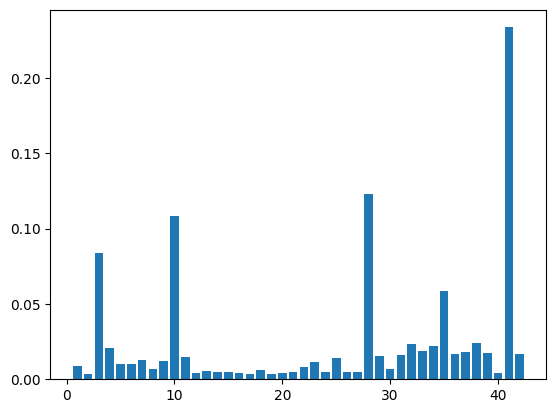

In [ ]:
#SHAP here
optimized_xgb.fit(X,Y)
checking_feature_imp(optimized_xgb)

##Ensemble Learning

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=42)

###Voting Method

In [ ]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier

ensemble_models = [('lgb', optimized_lgbm),
   ('xgb', optimized_xgb)]

voting_model = VotingClassifier(estimators= ensemble_models, voting= 'soft')
voting_model.fit(X, Y)

[LightGBM] [Warning] feature_fraction is set=0.7752743827110101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752743827110101
[LightGBM] [Warning] lambda_l2 is set=3.5512957384770685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5512957384770685
[LightGBM] [Warning] lambda_l1 is set=5.316935265388215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.316935265388215
[LightGBM] [Warning] bagging_fraction is set=0.9547952331300819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547952331300819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7752743827110101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752743827110101
[LightGBM] [Warning] lambda_l2 is set=3.5512957384770685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5512957384770685
[LightGBM] [Warning] lambda_l1 is set=

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.9547952331300819,
                                             bagging_freq=1,
                                             feature_fraction=0.7752743827110101,
                                             lambda_l1=5.316935265388215,
                                             lambda_l2=3.5512957384770685,
                                             learning_rate=0.07352154105869645,
                                             min_child_samples=16,
                                             n_estimators=285,
                                             num_leaves=241)),
                             ('xgb',
                              XGBClassifier(alpha=7.190639597290867,
                                            base_score=None, boost...
                                            gamma=0.1007505264830284,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            lambda=4.560467174555585,
                                            learning_rate=0.09488620663898428,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=461, ...))],
                 voting='soft')

In [ ]:
voting_model_val_preds = voting_model.predict(X_test)
voting_model_val_accuracy = accuracy_score(Y_test, voting_model_val_preds)
print(voting_model_val_accuracy)

[LightGBM] [Warning] feature_fraction is set=0.7752743827110101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7752743827110101
[LightGBM] [Warning] lambda_l2 is set=3.5512957384770685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5512957384770685
[LightGBM] [Warning] lambda_l1 is set=5.316935265388215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.316935265388215
[LightGBM] [Warning] bagging_fraction is set=0.9547952331300819, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9547952331300819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
0.9450310105984316


####Weight tuning with Voting Classifier and Optuna (using already tuned isolated models)

In [ ]:
def objective(trial):
    w_lgbm = trial.suggest_float("w_lgbm", 0.1, 10.0)
    w_xgb = trial.suggest_float("w_xgb", 0.1, 10.0)

    voting_clf = VotingClassifier(
        estimators=ensemble_models,
        voting='soft',
        weights=[w_lgbm, w_xgb]
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X, Y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        Y_train, Y_val = Y.iloc[train_idx], Y.iloc[val_idx]

        voting_clf.fit(X_train, Y_train)
        preds = voting_clf.predict(X_val)
        scores.append(accuracy_score(Y_val, preds))
    return sum(scores) / len(scores)

In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=200)

# Print the best weight
print('Best weight:', study.best_params)
print('Best accuracy: ', study.best_value)

In [ ]:
# Best weight: {'w_lgbm': 1.596707658175287, 'w_xgb': 8.599014298260096}
# Best accuracy:  0.9639927162479054
ensemble_models = [('lgb', optimized_lgbm),
   ('xgb', optimized_xgb)]

voting_model = VotingClassifier(estimators= ensemble_models, voting='soft', weights=[1.596707658175287, 8.599014298260096])

#### Joint Tuning with Voting Classifier

In [ ]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from statistics import mean
import optuna

# Assumes you already have X, Y, and cv defined

def objective(trial):
    # LightGBM params
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lgbm_lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lgbm_lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('lgbm_feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('lgbm_bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('lgbm_bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 400)
    }

    # XGBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('xgb_lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('xgb_alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('xgb_subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 500),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 10.0)
    }

    # CatBoost parameters
    cat_params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': trial.suggest_int('cat_iterations', 100, 500),
        'depth': trial.suggest_int('cat_depth', 3, 10),
        'learning_rate': trial.suggest_float('cat_learning_rate', 1e-4, 1e-1),
        'random_strength': trial.suggest_float('cat_random_strength', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_float('cat_bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('cat_border_count', 1, 255),
        'scale_pos_weight': trial.suggest_float('cat_scale_pos_weight', 0.1, 10.0),
        'verbose': 0
    }

    # Instantiate models
    lgbm = LGBMClassifier(**lgbm_params)
    xgb = XGBClassifier(**xgb_params)
    cat = CatBoostClassifier(**cat_params)

    # Weights for ensemble
    w_lgbm = trial.suggest_float("w_lgbm", 0.1, 10.0)
    w_xgb = trial.suggest_float("w_xgb", 0.1, 10.0)
    w_cat = trial.suggest_float("w_cat", 0.1, 10.0)

    ensemble = VotingClassifier(
        estimators=[
            ('lgbm', lgbm),
            ('xgb', xgb),
            ('cat', cat)
        ],
        voting='soft',
        weights=[w_lgbm, w_xgb, w_cat]
    )

    # Cross-validation
    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, Y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        Y_train, Y_val = Y.iloc[train_idx], Y.iloc[val_idx]
        ensemble.fit(X_train, Y_train)
        preds = ensemble.predict_proba(X_val)
        auc = roc_auc_score(Y_val, preds[:, 1])
        scores.append(auc)

    return mean(scores)


In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=200)

# Print the best weight
print('Best weight:', study.best_params)
print('Best accuracy: ', study.best_value)

In [ ]:
# {'lgbm_lambda_l1': 4.855796308823436, 'lgbm_lambda_l2': 1.8112910186742914, 'lgbm_num_leaves': 208, 'lgbm_feature_fraction': 0.764049612955413, 'lgbm_bagging_fraction': 0.9614629909022068, 'lgbm_bagging_freq': 2, 'lgbm_min_child_samples': 32, 'lgbm_learning_rate': 0.06543470275768253, 'lgbm_n_estimators': 305, 'xgb_lambda': 8.923058045955715, 'xgb_alpha': 6.123119381649882, 'xgb_colsample_bytree': 0.4333895770236075, 'xgb_subsample': 0.47655723941392947, 'xgb_learning_rate': 0.09703258014075122, 'xgb_n_estimators': 360, 'xgb_max_depth': 6, 'xgb_min_child_weight': 3, 'xgb_gamma': 2.2365791698635755, 'cat_iterations': 385, 'cat_depth': 5, 'cat_learning_rate': 0.02915893198223019, 'cat_random_strength': 9.268489564535674, 'cat_bagging_temperature': 0.7806793560503623, 'cat_l2_leaf_reg': 5.429814350529708, 'cat_border_count': 181, 'cat_scale_pos_weight': 1.451535654181624, 'w_lgbm': 6.15513939388916, 'w_xgb': 3.0235392985276004, 'w_cat': 8.989811656281585}
# Best accuracy:  0.9706136086780992


# Updated LightGBM parameters
best_params_lgbm = {
    'lambda_l1': 4.855796308823436,
    'lambda_l2': 1.8112910186742914,
    'num_leaves': 208,
    'feature_fraction': 0.764049612955413,
    'bagging_fraction': 0.9614629909022068,
    'bagging_freq': 2,
    'min_child_samples': 32,
    'learning_rate': 0.06543470275768253,
    'n_estimators': 305,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbosity': -1
}
optimized_lgbm = LGBMClassifier(**best_params_lgbm)

# Updated XGBoost parameters
best_params_xgb = {
    'lambda': 8.923058045955715,
    'alpha': 6.123119381649882,
    'colsample_bytree': 0.4333895770236075,
    'subsample': 0.47655723941392947,
    'learning_rate': 0.09703258014075122,
    'n_estimators': 360,
    'max_depth': 6,
    'min_child_weight': 3,
    'gamma': 2.2365791698635755,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}
optimized_xgb = XGBClassifier(**best_params_xgb)

# Updated CatBoost parameters
best_params_cat = {
    'iterations': 385,
    'depth': 5,
    'learning_rate': 0.02915893198223019,
    'random_strength': 9.268489564535674,
    'bagging_temperature': 0.7806793560503623,
    'l2_leaf_reg': 5.429814350529708,
    'border_count': 181,
    'scale_pos_weight': 1.451535654181624,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0
}
optimized_cat = CatBoostClassifier(**best_params_cat)

# Updated voting weights
voting_weights = [6.15513939388916, 3.0235392985276004, 8.989811656281585]

# Voting Classifier (soft voting)
voting_model = VotingClassifier(
    estimators=[
        ('lgbm', optimized_lgbm),
        ('xgb', optimized_xgb),
        ('cat', optimized_cat)
    ],
    voting='soft',
    weights=voting_weights,
    n_jobs=-1
)
voting_model.fit(X,Y)

###Stacking Method

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=42)
from sklearn.ensemble import StackingClassifier
final_estimator = LogisticRegression()

estimators = [('lgb', optimized_lgbm),
   ('xgb', optimized_xgb)]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator
)

# Train the stacking model
stacking_model.fit(X, Y)

# Evaluate the model
accuracy = stacking_model.score(X_test, Y_test)
print(f'Accuracy: {accuracy}')

[LightGBM] [Warning] feature_fraction is set=0.4735610475772436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4735610475772436
[LightGBM] [Warning] lambda_l2 is set=1.7436305410688773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7436305410688773
[LightGBM] [Warning] lambda_l1 is set=0.5715842498810308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5715842498810308
[LightGBM] [Warning] bagging_fraction is set=0.9430383408794584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430383408794584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4735610475772436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4735610475772436
[LightGBM] [Warning] lambda_l2 is set=1.7436305410688773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7436305410688773
[LightGBM] [Warning] lambda_l1 is se

#### Hypothesis: Cat+ LGBM or XGB has better generalization??

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

stack_a = StackingClassifier(
    estimators=[('xgb', optimized_xgb), ('lgbm', optimized_lgbm), ('cat', optimized_cat)],
    final_estimator=LogisticRegression()
)

stack_b = StackingClassifier(
    estimators=[('lgbm', optimized_lgbm), ('cat', optimized_cat)],
    final_estimator=LogisticRegression()
)

print("Stack A score:", cross_val_score(stack_a, X, Y, cv=5).mean())


In [ ]:
print("Stack B score:", cross_val_score(stack_b, X, Y, cv=5).mean())

#####Correlation between two models (XGB vs LGBM; XGB vs CAT)

In [ ]:
import numpy as np

# Assume you have predictions
pred_xgb = optimized_xgb.predict(X_test)
pred_lgbm = optimized_lgbm.predict(X_test)
pred_cat = optimized_cat.predict(X_test)

# Correlation between predictions
print(np.corrcoef(pred_xgb, pred_lgbm)[0,1])  # High = similar models
print(np.corrcoef(pred_xgb, pred_cat)[0,1])   # Lower = more diversity

####Tuning stacking models with optuna (using already tuned isolated models)

In [ ]:
def objective(trial):
    # Hyperparameters for meta-model (LogisticRegression)
    C = trial.suggest_float("C", 1e-4, 10.0, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", None])

    meta_model = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000)

    stack_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5,
        passthrough=False,
        n_jobs=-1
    )

    score = cross_val_score(stack_model, X_train, Y_train, cv=5, scoring='accuracy').mean()
    return score

# Optimize meta-model
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print('Best accuracy: ', study.best_value)

In [ ]:
C = 1.9243483755102326
penalty= None
meta_model = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000)
stacking_model = StackingClassifier(estimators=estimators, final_estimator= meta_model)

####Joint tuning with Stacking Classifier

In [ ]:
import optuna
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from statistics import mean
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

def objective(trial):
    # --- LightGBM Parameters ---
    lgbm_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lgbm_lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lgbm_lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('lgbm_feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('lgbm_bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('lgbm_bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 400)
    }

    # --- XGBoost Parameters ---
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('xgb_lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('xgb_alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('xgb_subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 500),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 10.0),
        'use_label_encoder': False
    }

    # --- CatBoost Parameters ---
    cat_params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'iterations': trial.suggest_int('cat_iterations', 100, 500),
        'depth': trial.suggest_int('cat_depth', 3, 10),
        'learning_rate': trial.suggest_float('cat_learning_rate', 1e-4, 1e-1),
        'random_strength': trial.suggest_float('cat_random_strength', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_float('cat_bagging_temperature', 0.0, 1.0),
        'l2_leaf_reg': trial.suggest_float('cat_l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('cat_border_count', 1, 255),
        'scale_pos_weight': trial.suggest_float('cat_scale_pos_weight', 0.1, 10.0),
        'verbose': 0
    }

    # Instantiate base models
    lgbm = LGBMClassifier(**lgbm_params)
    xgb = XGBClassifier(**xgb_params)
    cat = CatBoostClassifier(**cat_params)

    # --- Meta-model (final estimator) parameters ---
    C = trial.suggest_float("meta_C", 1e-4, 10.0, log=True)
    penalty = trial.suggest_categorical("meta_penalty", ["l2", None])

    meta_model = LogisticRegression(C=C, penalty=penalty, solver='lbfgs', max_iter=1000)

    # --- Define Stacking Classifier ---
    stack_model = StackingClassifier(
        estimators=[
            ('lgbm', lgbm),
            ('xgb', xgb),
            ('cat', cat)
        ],
        final_estimator=meta_model,
        cv=5,
        passthrough=False,
        n_jobs=-1
    )

    # --- Cross-validation ---
    scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, Y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        Y_train, Y_val = Y.iloc[train_idx], Y.iloc[val_idx]

        stack_model.fit(X_train, Y_train)
        preds = stack_model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(Y_val, preds)
        scores.append(auc)

    return mean(scores)

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial AUC:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-08-01 02:12:04,325] A new study created in memory with name: no-name-d48dd438-b599-4ef5-b50a-c372917fdd44
[W 2025-08-01 02:12:08,002] Trial 0 failed with parameters: {'lgbm_lambda_l1': 4.108907176954179, 'lgbm_lambda_l2': 7.227376182626581, 'lgbm_num_leaves': 158, 'lgbm_feature_fraction': 0.5583486952609918, 'lgbm_bagging_fraction': 0.4212197566879216, 'lgbm_bagging_freq': 5, 'lgbm_min_child_samples': 73, 'lgbm_learning_rate': 0.06261824411390171, 'lgbm_n_estimators': 212, 'xgb_lambda': 8.94262400293321, 'xgb_alpha': 3.9165253419267203, 'xgb_colsample_bytree': 0.5983759573496008, 'xgb_subsample': 0.5081472639840574, 'xgb_learning_rate': 0.0329222729909194, 'xgb_n_estimators': 141, 'xgb_max_depth': 4, 'xgb_min_child_weight': 10, 'xgb_gamma': 8.818144358244407, 'cat_iterations': 469, 'cat_depth': 7, 'cat_learning_rate': 0.07717700357137576, 'cat_random_strength': 2.4679056522063885, 'cat_bagging_temperature': 0.3622265519849095, 'cat_l2_leaf_reg': 7.480099193396852, 'cat_border_c

KeyboardInterrupt: 

In [ ]:
# {'lgbm_lambda_l1': 3.705494427598681, 'lgbm_lambda_l2': 8.447007757006228, 'lgbm_num_leaves': 142, 'lgbm_feature_fraction': 0.6894756022914302, 'lgbm_bagging_fraction': 0.9473941142597405, 'lgbm_bagging_freq': 7, 'lgbm_min_child_samples': 41, 'lgbm_learning_rate': 0.04788130878081352, 'lgbm_n_estimators': 211, 'xgb_lambda': 1.3182016190336703, 'xgb_alpha': 6.37631189727107, 'xgb_colsample_bytree': 0.9086990746953332, 'xgb_subsample': 0.43561307852724734, 'xgb_learning_rate': 0.05861461781004101, 'xgb_n_estimators': 290, 'xgb_max_depth': 8, 'xgb_min_child_weight': 2, 'xgb_gamma': 3.0917168603580096, 'cat_iterations': 407, 'cat_depth': 7, 'cat_learning_rate': 0.025082804546448952, 'cat_random_strength': 6.257049617299793, 'cat_bagging_temperature': 0.4184547890595095, 'cat_l2_leaf_reg': 2.5994547784631368, 'cat_border_count': 231, 'cat_scale_pos_weight': 1.030451497061311, 'meta_C': 0.54079511771124, 'meta_penalty': None}.
# Best is trial 129 with value: 0.9705451120262247.


best_params_lgbm = {
    'lambda_l1': 3.705494427598681,
    'lambda_l2': 8.447007757006228,
    'num_leaves': 142,
    'feature_fraction': 0.6894756022914302,
    'bagging_fraction': 0.9473941142597405,
    'bagging_freq': 7,
    'min_child_samples': 41,
    'learning_rate': 0.04788130878081352,
    'n_estimators': 211,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbosity': -1
}
optimized_lgbm = LGBMClassifier(**best_params_lgbm)

# Optimized XGBoost parameters
best_params_xgb = {
    'lambda': 1.3182016190336703,
    'alpha': 6.37631189727107,
    'colsample_bytree': 0.9086990746953332,
    'subsample': 0.43561307852724734,
    'learning_rate': 0.05861461781004101,
    'n_estimators': 290,
    'max_depth': 8,
    'min_child_weight': 2,
    'gamma': 3.0917168603580096,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}
optimized_xgb = XGBClassifier(**best_params_xgb)

# Optimized CatBoost parameters
best_params_cat = {
    'iterations': 407,
    'depth': 7,
    'learning_rate': 0.025082804546448952,
    'random_strength': 6.257049617299793,
    'bagging_temperature': 0.4184547890595095,
    'l2_leaf_reg': 2.5994547784631368,
    'border_count': 231,
    'scale_pos_weight': 1.030451497061311,
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0
}
optimized_cat = CatBoostClassifier(**best_params_cat)

# Meta-classifier: Logistic Regression
meta_model = LogisticRegression(
    C=0.54079511771124,
    penalty='l2',  # Assuming default 'l2' since 'None' was provided
    solver='lbfgs',
    max_iter=1000
)

# Stacking Classifier setup
stacking_model = StackingClassifier(
    estimators=[
        ('lgbm', optimized_lgbm),
        ('xgb', optimized_xgb),
        ('cat', optimized_cat)
    ],
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)

In [ ]:
stacking_model.fit(X,Y)

#Final Solutions

In [40]:
# optimized_cat.fit(X, Y)

In [41]:
X

,age,default,housing,loan,day,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,42,0,0,0,25,3,-1,0,2.079442,4.770685,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,38,0,0,0,18,1,-1,0,6.244167,5.225747,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True
2,36,0,1,0,14,2,-1,0,6.401917,4.718499,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,27,0,1,0,28,2,-1,0,3.555348,2.397895,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,26,0,1,0,3,1,-1,0,6.791221,6.805723,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,51,0,0,0,17,3,-1,0,6.716595,6.885510,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795207,71,0,0,0,17,2,-1,0,7.455877,6.124683,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
795208,72,0,0,0,17,5,184,3,8.651025,7.028201,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
795209,57,0,0,0,17,4,-1,0,6.505784,6.232448,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [42]:
test_data = test_data.drop(columns =['id'])
test_data

,age,default,housing,loan,day,campaign,pdays,previous,balance_log,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,32,0,1,0,21,1,-1,0,7.242798,5.416100,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,44,0,1,0,3,2,-1,0,3.178054,6.375025,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,36,0,1,1,13,2,-1,0,3.850148,4.718499,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,58,0,1,1,29,1,-1,0,0.000000,4.836282,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,28,0,1,0,22,1,-1,0,7.576097,5.204007,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,43,0,1,0,18,2,-1,0,0.000000,4.189655,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
249996,40,0,1,0,19,1,189,1,6.259581,6.276643,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
249997,63,0,0,0,3,1,92,8,3.526361,5.187386,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
249998,50,0,1,0,30,2,-1,0,7.874739,5.099866,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True


In [43]:
solution = stacking_model.predict_proba(test_data)
solution = solution[:, 1]
solution

[LightGBM] [Warning] feature_fraction is set=0.4735610475772436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4735610475772436
[LightGBM] [Warning] lambda_l2 is set=1.7436305410688773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7436305410688773
[LightGBM] [Warning] lambda_l1 is set=0.5715842498810308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5715842498810308
[LightGBM] [Warning] bagging_fraction is set=0.9430383408794584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9430383408794584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


array([0.01860651, 0.04944455, 0.01837376, ..., 0.80401647, 0.01841686,
       0.03066872])

In [44]:
sample = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Classification/Binary Classification with a Bank Dataset/sample_submission.csv')
sample['y'] = solution
sample


,id,y
0,750000,0.018607
1,750001,0.049445
2,750002,0.018374
3,750003,0.018322
4,750004,0.021456
...,...,...
249995,999995,0.018321
249996,999996,0.035843
249997,999997,0.804016
249998,999998,0.018417


In [45]:
from google.colab import files

sample.to_csv('stacking_xgb_lgbm_5.csv', index=False)
files.download('stacking_xgb_lgbm_5.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>